In [23]:
from sim_data import *
import numpy as np

# set seed for reproducibility
np.random.seed(23750)

# iIRF parameters
rep_rate = 40
k = 512
fwhm = 0.2

# iIRF only needs to be generated once
# it is measured one time and the sa
# me for all signals
iirf, t = gaussian_irf(rep_rate, k, fwhm)

nonZeroIdx = np.argmin(np.abs(iirf[:int(len(iirf)/2)] - 1/20))
iirf_aligned = 0.5 * np.roll(iirf, -nonZeroIdx)

# number of sets to generate
N = 1000



8.492569002123144e-11
0.0 4.8923679060665357e-11 1.25e-08 2.5e-08


In [24]:
# fractional contributions and taus randomly generated
# in this case, based on the information in the paper,
# fractional contributions are generated from a uniform distribution between 
# 0 and 100%
# and taus are randomly generated from a uniform distribution between 1 and 6 ns
# and the number of exponential components generated is randomly picked from 1-6
rng = np.random.default_rng(12345)
M = rng.integers(low=1, high=6, size=N)
# TODO order fracs and taus correctly for input into gen_signal
parts = [rng.random(m) for m in M]
fracs = [parts[n] / sum(parts[n]) for n in range(N)]
taus = [rng.uniform(low = 1, high = 6, size = m) for m in M]



In [ ]:
tau_avgs_true = np.zeros(np.size(N))
for life in zip(fracs, taus):
    tau_avgs_true += sum(life[0] * 100 * life[1])

In [25]:
decays = []
for n in range(N):
    decay, t = gen_signal(rep_rate, k, fracs[n], taus[n], iirf)
    noisy_decay = add_white_noise(decay, 20)
    decays.append(noisy_decay)

In [26]:
import matplotlib.pyplot as plt

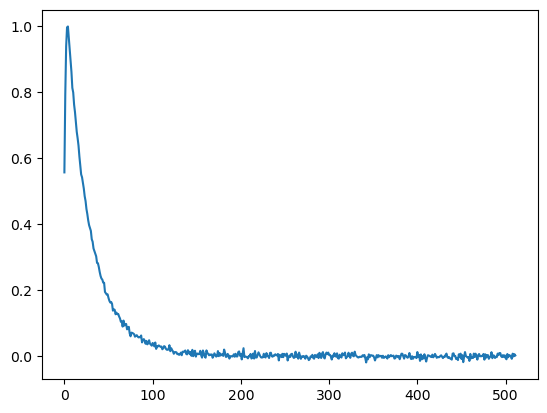

In [27]:

plt.plot(decays[0])

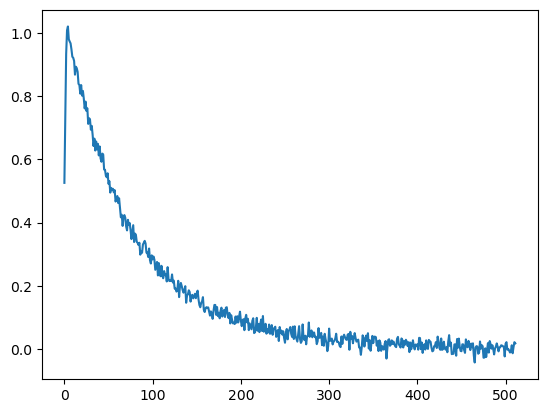

In [28]:
plt.plot(decays[800])

In [29]:
from compute_V import *
from laguerre_basis import *

In [30]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

(512,)
Coefficients: 
 [ 0.         40.95459214  0.         50.4061863   0.         53.34908546
 32.01038818  0.        ]
Mean squared error: 0.00
Coefficient of determination: 0.96


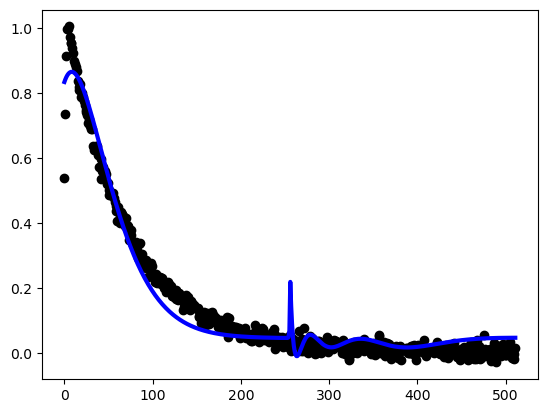

In [31]:
i = 129
alpha = 0.9
L = 8
V = compute_V(k, alpha, L, iirf_aligned)
regr = linear_model.LinearRegression(positive = True)
regr.fit(V, decays[i])
y_pred = regr.predict(V)
print(y_pred.shape)
print("Coefficients: \n", regr.coef_)
print("Mean squared error: %.2f" % mean_squared_error(decays[i], y_pred))
print("Coefficient of determination: %.2f" % r2_score(decays[i], y_pred))
plt.scatter(np.arange(k), decays[i], color="black")
plt.plot(np.arange(k), y_pred, color="blue", linewidth=3)
plt.show()

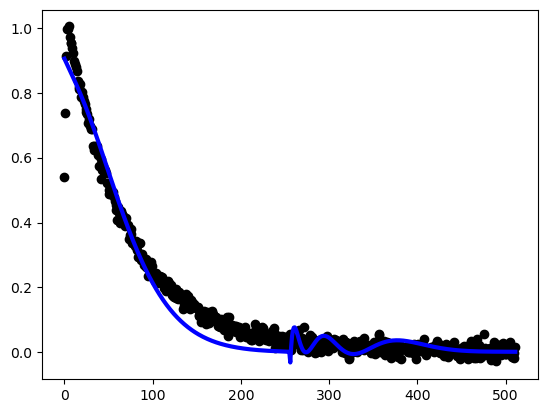

In [32]:

chat = np.linalg.inv(np.transpose(V) @ V) @ np.transpose(V) @ decays[i]
ypred = V @ chat

plt.scatter(np.arange(k), decays[i], color="black")
plt.plot(np.arange(k), ypred, color="blue", linewidth=3)
plt.show()

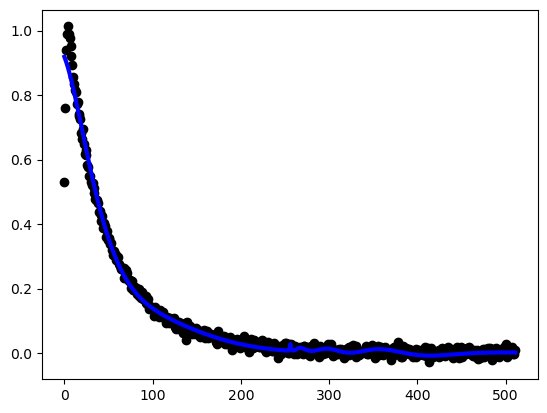

In [33]:
i = 232
k = 512
V = compute_V(k, 0.9, 12, iirf_aligned)

chat = np.linalg.inv(np.transpose(V) @ V) @ np.transpose(V) @ decays[i]
ypred = V @ chat

plt.scatter(np.arange(k), decays[i], color="black")
plt.plot(np.arange(k), ypred, color="blue", linewidth=3)
plt.show()

(512,)
Coefficients: 
 [ 0.         40.95459214  0.         50.4061863   0.         53.34908546
 32.01038818  0.        ]
Mean squared error: 0.00
Coefficient of determination: 0.96


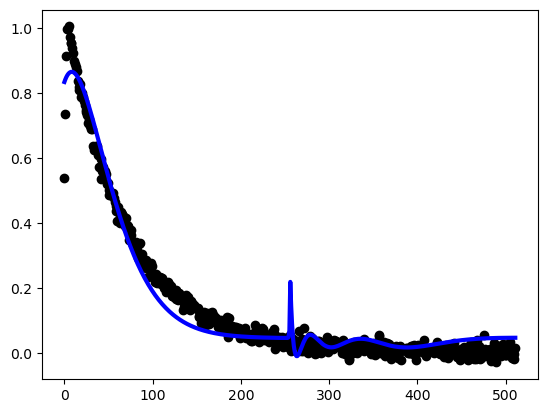

In [34]:
i = 129
alpha = 0.9
L = 8
V = compute_V(512, alpha, L, iirf_aligned)
k = 512
regr = linear_model.LinearRegression(positive = True)
regr.fit(V, decays[i])
y_pred = regr.predict(V)
print(y_pred.shape)
print("Coefficients: \n", regr.coef_)
print("Mean squared error: %.2f" % mean_squared_error(decays[i], y_pred))
print("Coefficient of determination: %.2f" % r2_score(decays[i], y_pred))
plt.scatter(np.arange(k), decays[i], color="black")
plt.plot(np.arange(k), y_pred, color="blue", linewidth=3)
plt.show()

In [36]:

# k values from 0 to N
k = np.arange(512)
# compute basis array
basis_array = np.vstack(
    [single_basis(k, alpha, l) for l in range(L)]
    )
basis_array = np.transpose(basis_array)

In [37]:
h = basis_array @ regr.coef_
# equation 13 page 7
kh = k * h
kh = np.reshape(kh, (512,1))
kh = kh[::-1]
b = np.sum(kh)
dt = t[1] #whatever delta t is
tauavg = dt * b / np.sum(kh)
print(tauavg)

4.8923679060665357e-11
